In [47]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device
from pysr import pysr, best
from tqdm import tqdm
torch.manual_seed(42)
random.seed(42)


print('Loading data')

case='vlarge_all_4t_z0.0_quantile_raw'

datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))

try:
    n_targ=len(data[0].y)
except:
    n_targ=1
n_feat=len(data[0].x[0])
n_feat, n_targ

print('Loaded data')


Loading data
Loaded data


In [48]:
model_folder = osp.expanduser('~/../../scratch/gpfs/cj1223/GraphResults')
group = 'results_meta_pysr_120322'
run = 'MetaEdge_vlarge_all_4t_z0.0_quantile_raw_hfpmye'

model_path= osp.join(model_folder, group, run)
construct = pickle.load(open(osp.join(model_path, 'construct_dict.pkl'), 'rb'))
results = pickle.load(open(osp.join(model_path, 'result_dict.pkl'), 'rb'))


model = construct['model']

os.chdir('..')

def setup_model(model_name, hyper_params):
    # Retrieve name and params for construction

    # Load model from model folder
    import dev.models as models
    model         = getattr(models, model_name) 
    model         = model(**hyper_params)

    return model

model = setup_model(model, construct['hyper_params'])

os.chdir('pysr')

model.load_state_dict(torch.load(osp.join(model_path, 'trained_model', 'model_best.pt')))

RelU conv activation
LeakyRelU decode activation


<All keys matched successfully>

In [49]:

batch_size=int(2**8) # 8-256
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
# train_data, test_data=train_test_split(data, test_size=0.2)

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)

test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0, num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function
def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    varss = []
    with torch.no_grad(): ##this solves it!!!
        for dat in tqdm(loader, total=len(loader)): 
            
            out, var = model(dat) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
            varss.append(var)
            
    outss=torch.vstack(outs)
    varss=torch.vstack(outs)
    
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss, varss

GPU  False


In [50]:
results

{'sigma': [array([0.09376801, 0.03378351, 0.19444557, 0.35171744], dtype=float32)],
 'test_acc': [array([0.093647  , 0.03364303, 0.19445114, 0.35135224], dtype=float32),
  array([0.9135612, 0.0970052, 0.5353335, 0.9843488], dtype=float32),
  array([0.5910132 , 0.08898401, 0.5353486 , 0.6369817 ], dtype=float32),
  array([0.5258665 , 0.08005344, 0.5352915 , 0.5690871 ], dtype=float32),
  array([0.39285287, 0.07404925, 0.5352662 , 0.5401576 ], dtype=float32),
  array([0.26816955, 0.07428045, 0.53522474, 0.5262955 ], dtype=float32),
  array([0.25077948, 0.07039093, 0.53521633, 0.50957423], dtype=float32),
  array([0.2560273 , 0.06913187, 0.5351986 , 0.5122538 ], dtype=float32),
  array([0.23713616, 0.0696125 , 0.5351341 , 0.50416416], dtype=float32),
  array([0.30203703, 0.07073075, 0.5350826 , 0.5438215 ], dtype=float32),
  array([0.2176217 , 0.06772655, 0.5349763 , 0.5010747 ], dtype=float32),
  array([0.24356411, 0.07036656, 0.535048  , 0.5273227 ], dtype=float32),
  array([0.21209572,

In [51]:
test_acc, preds , ys, var = test(test_loader)
print(f'Test scatter: {np.round(test_acc.cpu().numpy(), 4)}')

100%|███████████████████████████████████████████████████████████████| 86/86 [01:14<00:00,  1.15it/s]

Test scatter: [0.0921 0.7799 0.723  0.4079]


## Model sizing

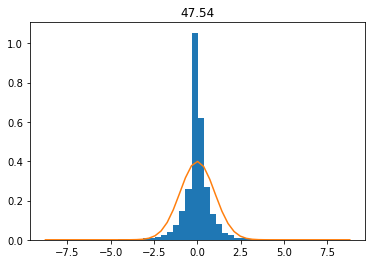

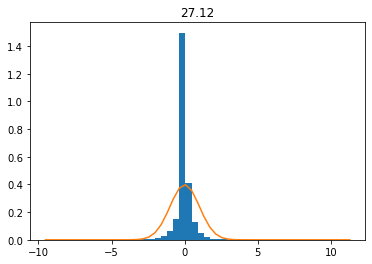

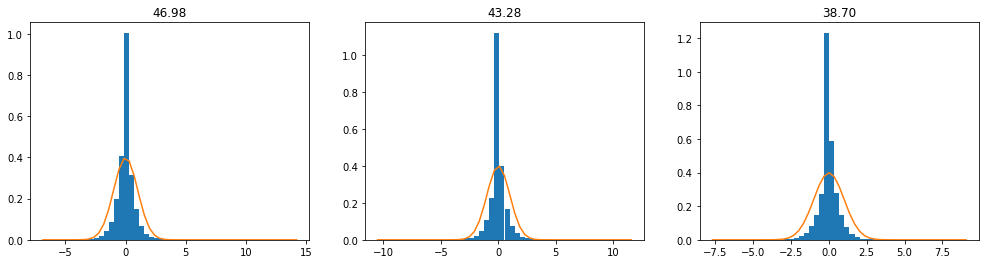

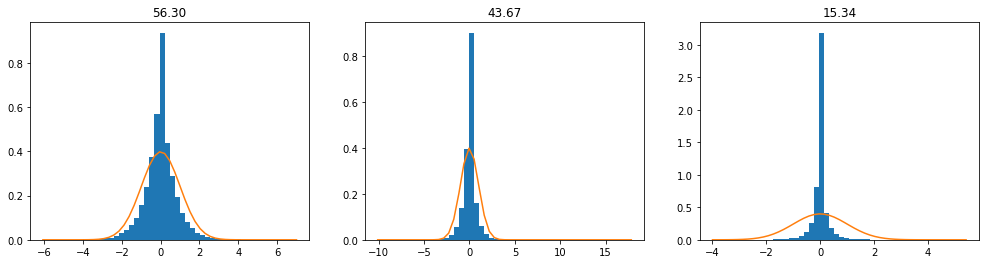

In [104]:
# labels = ['node']

from scipy.stats import norm

node = [p.detach().numpy().flatten() for p in model.node_enc.parameters()]
nodep = np.hstack(node)

fig, ax = plt.subplots()

vals, bine, fig = ax.hist(nodep, bins=50, density=1)
ax.plot(bine, norm.pdf(bine,0,1))
ax.set_title(f'{sum(abs(nodep))/len(nodep)*100:.2f}')

edge = [p.detach().numpy().flatten() for p in model.edge_enc.parameters()]
edgep = np.hstack(edge)

fig, ax = plt.subplots()

vals, bine, fig = ax.hist(edgep, bins=50, density=1)
ax.plot(bine, norm.pdf(bine,0,1))
ax.set_title(f'{sum(abs(edgep))/len(edgep)*100:.2f}')

for conv in model.convs:
    
    edge = [p.detach().numpy().flatten() for p in conv.edge_model.parameters()]
    edgep = np.hstack(edge)

    node1 = [p.detach().numpy().flatten() for p in conv.node_model.node_mlp_1.parameters()]
    node1p = np.hstack(node1)

    node2 = [p.detach().numpy().flatten() for p in conv.node_model.node_mlp_2.parameters()]
    node2p = np.hstack(node2)
    
    fig, ax =plt.subplots(1, 3, figsize=(17,4))
    ax = ax.flatten()
    
    vals, bine, fig = ax[0].hist(node1p, bins=50, density=1)
    ax[0].plot(bine, norm.pdf(bine,0,1))
    ax[0].set_title(f'{sum(abs(node1p))/len(node1p)*100:.2f}')
    
    vals, bine, fig = ax[1].hist(node2p, bins=50, density=1)
    ax[1].plot(bine, norm.pdf(bine,0,1))
    ax[1].set_title(f'{sum(abs(node2p))/len(node2p)*100:.2f}')
    
    vals, bine, fig = ax[2].hist(edgep, bins=50, density=1)
    ax[2].plot(bine, norm.pdf(bine,0,1))
    ax[2].set_title(f'{sum(abs(edgep))/len(edgep)*100:.2f}')
# model.convs[0]


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (7): Linear(in_features=64, out_features=128, bias=True)
  )
)

In [82]:
# print('node encoder', sum(layer.abs().sum() for layer in model.node_enc.parameters())/\
#       sum(layer.numel() for layer in model.node_enc.parameters())*100)

node = [p.detach().numpy().flatten() for p in model.node_enc.parameters()]
nodep = np.hstack(node)

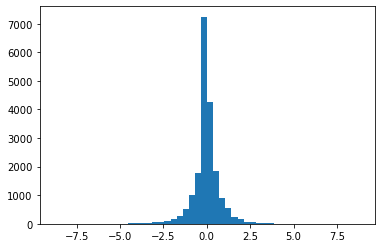

In [79]:
plt.hist(nodep, bins=50);

In [81]:
sum(abs(nodep))/len(nodep)

0.47544093954918626

In [22]:
from datetime import date
today = date.today()

today = today.strftime("%d%m%y")

torch.save(model.state_dict(),f'trained_models/model_{epoch}_{today}.pt') 

In [24]:
load=False
if load:
    model = GCN(hidden_channelse=128)
    model.load_state_dict(torch.load(f'trained_models', f'model_{epoch}_{date}.pt'))

In [25]:
print('decoder', sum(p.abs().sum() for p in model.f.parameters())/sum(p.numel() for p in model.f.parameters())*100)

print('encoder', sum(p.abs().sum() for p in model.g1.parameters())/sum(p.numel() for p in model.g1.parameters())*100)
print('edge', sum(p.abs().sum() for p in model.g2.parameters())/sum(p.numel() for p in model.g2.parameters())*100)
print('both', sum(p.abs().sum() for p in model.g3.parameters())/sum(p.numel() for p in model.g3.parameters())*100)

decoder tensor(1.0244, grad_fn=<MulBackward0>)
encoder tensor(1.0797, grad_fn=<MulBackward0>)
edge tensor(0.5381, grad_fn=<MulBackward0>)
both tensor(1.1271, grad_fn=<MulBackward0>)


In [27]:
# model.load_state_dict(torch.load(osp.join(pointer, model_runs[k], 'trained_model', 'model.pt')))

In [84]:
pysr_loader=DataLoader(test_data[:50], batch_size=batch_size, shuffle=0, num_workers=4)    

y_f = []
y_g1 = []
y_g2 = []
y_g3 = []
x_g1 = []
y_t = []
batch = []
i=0
for dat in pysr_loader:
    print(i)
    x_g1.append(dat.x.cpu().detach().numpy())
    yg1=model.g1(dat.x)
    y_g1.append(yg1.cpu().detach().numpy())
    
    adj = dat.edge_index
    neighbours = yg1
    xg2 = scatter_add(neighbours[adj[0]], adj[1], dim=0)
    x_g2.append(xg2)
    yg2=model.g2(xg2)
    y_g2.append(yg2.cpu().detach().numpy())
    
    yg1[adj[1]]+=yg2[adj[1]]
    
    yg3 = model.g3(yg1)
    y_g3.append(yg3.cpu().detach().numpy())
    x_f = global_add_pool(yg3, dat.batch)
    
    yf = model.f(x_f)
    y_f.append(yf.cpu().detach().numpy())
    
    batch.append(dat.batch.cpu().detach().numpy())
    y_t.append(dat.y.cpu().detach().numpy())
    i+=1

0


In [85]:
N=25
vals, counts = np.unique(batch[0], return_counts=1)
l = np.cumsum(counts)[N-1]
x_g1_pysr=np.vstack(x_g1[0][:l])
y_g1_pysr=np.vstack(y_g1[0][:l])
y_g2_pysr=np.vstack(y_g2[0][:l])
y_g3_pysr=np.vstack(y_g3[0][:l])
y_f_pysr=np.vstack(y_f[0][:l])

b_pysr = batch[0][:l]

In [86]:
##
g1_equations = pysr(
    X=x_g1_pysr, y=y_g1_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div"],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpyc0xp9yp/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 6.440e+03
Head worker occupation: 6.6%
Progress: 3 / 1200 total iterations (0.250%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           9.573e-01  7.446e-02  (-0.39906436 + (2.5171049 * x1))
7           7.673e-01  1.106e-01  (-0.2528663 + (x4 + (2.1287289 * x1)))
8           7.581e-01  1.199e-02  ((2.0636811 * x1) + log_abs(0.94439185 + x4))
9           6.789e-01  1.104e-01  (x1 + ((-0.57546425 * x0) + (3.2942095 * x2)))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.371e+00  2.264e-01  x1
2           9.097e+00  2.968e-02  exp(x1)
3           6.752e+00  2.981e-01  (2.793


Cycles per second: 3.380e+03
Head worker occupation: 0.9%
Progress: 13 / 1200 total iterations (1.083%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.3797928 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.178e-01  9.897e-04  (x1 - (0.009313339 + log10_abs(x2)))
7           6.145e-01  5.290e-03  (x1 - (log_abs(sqrt_abs(x2)) - -0.10132865))
8           5.698e-01  7.561e-02  (1.8673731 + (x1 + (-2.3141558 * sqrt_abs(x2))))
10          5.679e-01  1.624e-03  (x1 + (-1.0557032 * log10_abs(x2 + (-0.1134993 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.088e+00  4.701e-01  (4.234271 * x2)
5           8.302e-01  1.354e-01  (x4 - (x1 / -0.49075502))
7           7.658e-01  4.035e


Cycles per second: 2.680e+03
Head worker occupation: 0.5%
Progress: 21 / 1200 total iterations (1.750%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.990e-01  8.240e-02  (x1 + 0.34660563)
4           6.190e-01  2.553e-01  (x1 - log10_abs(x2))
7           5.908e-01  1.554e-02  ((2.9686167 * x1) + (-3.5632546 * x2))
8           5.679e-01  3.962e-02  ((2.3849034 - log_abs(x1)) * (x1 - x2))
10          5.659e-01  1.701e-03  (x1 + (-1.07813 * log10_abs(x2 + (-0.09936239 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           8.290e-01  1.464e-01  (x4 + (2.076545 * x1))
7           7.673e-01  3.867e-02  (-0.25267908 + (x4 + (2.1288564 * x1)))
9           6.693e-01  6.832e-02  (-0.544885


Cycles per second: 2.770e+03
Head worker occupation: 0.7%
Progress: 30 / 1200 total iterations (2.500%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.37972298 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.140e-01  4.015e-03  (x1 + log10_abs(0.85042274 / x2))
8           6.078e-01  5.104e-03  (x1 + log10_abs(-0.3060487 + (0.8593486 / x2)))
9           5.971e-01  1.785e-02  ((x1 - log10_abs(x2 * sqrt_abs(x1))) - 0.18158987)
10          5.677e-01  5.047e-02  (x1 + log10_abs((-1.0497826 / x2) + (-0.7018149 * x3)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.232e+00  4.080e-01  (x1 / 0.48811185)
5           8.337e-01  1.954e-01  ((x1 + x4) + x1)
8           8.279e-01  2.349e-03 

Killing process... will return when done.


In [87]:
eq = g1_equations[0].sort_values(by='score', ascending=False).iloc[0]
a=eq['lambda_format'](x_g1[0])
eq

Complexity                                                4
MSE                                                0.618991
score                                              0.253895
Equation                               (x1 - log10_abs(x2))
sympy_format                      x1 - log(Abs(x2))/log(10)
lambda_format    PySRFunction(X=>x1 - log(Abs(x2))/log(10))
Name: 2, dtype: object

In [88]:
eq = g1_equations[1].sort_values(by='score', ascending=False).iloc[0]
b=eq['lambda_format'](x_g1[0])
eq

Complexity                                          3
MSE                                          1.143048
score                                        0.445626
Equation                            (x1 / 0.37977126)
sympy_format                      2.63316397349289*x1
lambda_format    PySRFunction(X=>2.63316397349289*x1)
Name: 1, dtype: object

In [89]:
eq = g1_equations[2].sort_values(by='score', ascending=False).iloc[0]
c=eq['lambda_format'](x_g1[0])
eq

Complexity                                   3
MSE                                   6.751929
score                                 0.298143
Equation                      (2.7937005 * x1)
sympy_format                      2.7937005*x1
lambda_format    PySRFunction(X=>2.7937005*x1)
Name: 2, dtype: object

In [90]:
g1_an_pysr = np.vstack([a,b,c])

In [ ]:
g2_equations = pysr(
    X=y_g1_pysr, y=y_g2_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div", 'pow'],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpgyms7yzv/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 5.180e+03
Head worker occupation: 8.3%
Progress: 2 / 1200 total iterations (0.167%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  -0.000e+00  1.2790511
4           8.282e-01  6.981e-02  sqrt_abs(1.3321475 - x0)
5           5.994e-01  3.233e-01  (1.2852532 + (-0.26651594 * x1))
6           5.982e-01  2.089e-03  sqrt_abs(1.9554164 + (-0.6193561 * x1))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.950e+03
Head worker occupation: 5.1%
Progress: 3 / 1200 total iteration


Cycles per second: 3.420e+03
Head worker occupation: 0.7%
Progress: 10 / 1200 total iterations (0.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171164 * x1)
5      


Cycles per second: 5.100e+03
Head worker occupation: 0.5%
Progress: 22 / 1200 total iterations (1.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171337 * x1)
5      


Cycles per second: 4.950e+03
Head worker occupation: 0.4%
Progress: 35 / 1200 total iterations (2.917%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.2517181 * x1)
5       